**"I / we certify that the code and data in this assignment were generated independently, using only the tools
and resources defined in the course and that I/we did not receive any external help, coaching, or contributions
during the production of this work."**

In [1]:
from ast import arg
import numpy as np
import argparse
from copy import deepcopy
import torch
import gym
from boids import parallel_env as penv
from boids import config
from ddpg import DDPG
from args import parameter_args
from ou_noise import ouNoise
from replay import Prioritized_Experience_Replay as PER
from gym.spaces import Box
import warnings
warnings.filterwarnings("always")
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os

In [2]:

def collect_experience(env,obs,args,agent_per,adversary_per,agent_ddpg,adversary_ddpg,agent_noise,adversary_noise):
    count=0
    DONE=False
    score_agent=0
    score_adversary=0
    done = env.aec_env.dones
    # print(done)
    while not DONE:
        # print("Iteration Count ",count)
        actions={}
        loss={}
        for key in obs:
            if(key.find('adversary') != -1):
                if done[key] == False:
                    temp=adversary_ddpg.get_actions(obs[key])
                    # print("NN ", temp)
                    # temp=temp.detach().numpy() + adversary_noise.add_noise()
                    # print("Noise ", temp)
                    actions[key]=temp.detach().numpy().astype(np.float32)
                    actions[key] = np.clip(actions[key], env.action_space(key).low[0], env.action_space(key).high[0])
                else:
                     actions[key] = None

            else:
                if done[key] == False:
                    temp=agent_ddpg.get_actions(obs[key])
                    # temp=temp.detach().numpy() + agent_noise.add_noise()
                    actions[key]=temp.detach().numpy().astype(np.float32)
                    actions[key] = np.clip(actions[key], env.action_space(key).low[0], env.action_space(key).high[0])
                    # actions[key] = np.array([1,0,0,0,1])
                else: 
                    actions[key] = None
        nex_obs, reward, done,_= env.step(actions)
        # print(nex_obs)
        env.render()
        # print(actions['agent_0'])
        loss=0
        for key in obs:
            if(key.find('adversary') != -1):
                loss=adversary_ddpg.get_loss(obs[key],actions[key],nex_obs[key])
                adversary_per.push(loss,obs[key],actions[key],reward[key],nex_obs[key],done[key])
                score_adversary+=reward[key]
            else:
                loss=agent_ddpg.get_loss(obs[key],actions[key],nex_obs[key])
                agent_per.push(loss,obs[key],actions[key],reward[key],nex_obs[key],done[key])
                score_agent+=reward[key]
        obs=nex_obs
        count+=1
        if(count>=args.timesteps or all(x==True for x in done.values())):
            DONE=True
    print("Adversary Reward ", score_adversary)
    print("Agent Reward",score_agent )
    # env.close()
    return score_agent,score_adversary


In [3]:


if __name__ == "__main__":
    env = penv(config=config)
    obs=env.reset()
    num_states_agent=env.observation_space('agent_0').shape[0]
    num_states_adv=env.observation_space('adversary_0').shape[0]

    num_actions=env.action_space('agent_0').shape[0]
    args=parameter_args()
    
    agent_per=PER(args.buffer_size_agent,args.exp_alpha,args.batch_size)
    adversary_per=PER(args.buffer_size_adversary,args.exp_alpha,args.batch_size)

    agent_model_path = 'agent_ddpg.pth'
    adversary_model_path = 'adversary_ddpg.pth'

    agent_ddpg=DDPG(num_states_agent,num_actions,args)
    adversary_ddpg=DDPG(num_states_adv,num_actions,args)
    
    if (os.path.isfile(agent_model_path)):
        print("Found the Agent DDPG Model, loading that")
        agent_ddpg_temp = torch.load(agent_model_path)
        agent_ddpg.actor.load_state_dict(agent_ddpg_temp.actor.state_dict())
        agent_ddpg.target_actor.load_state_dict(agent_ddpg_temp.target_actor.state_dict())

    
    if (os.path.isfile(adversary_model_path)):
        print("Found the Adversary DDPG Model, loading that")
        adversary_ddpg_temp = torch.load(adversary_model_path)
        adversary_ddpg.actor.load_state_dict(adversary_ddpg_temp.actor.state_dict())
        adversary_ddpg.target_actor.load_state_dict(adversary_ddpg_temp.target_actor.state_dict())

    
    
    agent_noise=ouNoise(np.zeros(env.action_space('agent_0').shape[0]))
    adversary_noise=ouNoise(np.zeros(env.action_space('agent_0').shape[0]))
    agent_scores=[]
    adversary_scores=[]
    train_agent = True
    train_count = 0
    for i in range(args.epoch):
       
        print("Current Epoch ",i)
        obs=env.reset()
        train_count += 1
        score_agent,score_adversary= collect_experience(env,obs,args,agent_per,adversary_per,agent_ddpg,adversary_ddpg,agent_noise,adversary_noise)
        agent_scores.append(score_agent)
        adversary_scores.append(score_adversary)
        final_scores = np.add(agent_scores,  adversary_scores)
        if train_agent and (len(agent_per.buffer)>=args.batch_size):
            print("Training Agent")
            agent_ddpg.policyUpdate(agent_per,args.buffer_size_agent)
            # if i%5==0
            agent_ddpg.saveModel(name='agent')
        elif not train_agent and  (len(adversary_per.buffer)>=args.batch_size):
            print("Training Adversary")
            adversary_ddpg.policyUpdate(adversary_per,args.buffer_size_adversary)
            adversary_ddpg.saveModel(name='adversary')
        
           
        if train_count == 10:
            train_agent = not train_agent
            train_count = 0
        clear_output(wait=True)
        figure, axis = plt.subplots(1,3)
        figure.set_figheight(5)
        figure.set_figwidth(20)
        axis[0].plot(agent_scores)
        axis[0].set_title("Agent Scores")
        axis[1].plot(adversary_scores)
        axis[1].set_title("Adversary Scores")
        axis[2].plot(final_scores)
        axis[2].set_title("Added Scores")
        
        plt.show()
        plt.pause(0.01)
        
    env.close()
    # clear_output(wait=True)


KeyboardInterrupt: 

In [ ]:
env.close()

In [7]:
torch.save(agent_ddpg, "agent_ddpg.pth")
torch.save(adversary_ddpg, "adversary_ddpg.pth")

Text(0.5, 1.0, 'Added Scores')

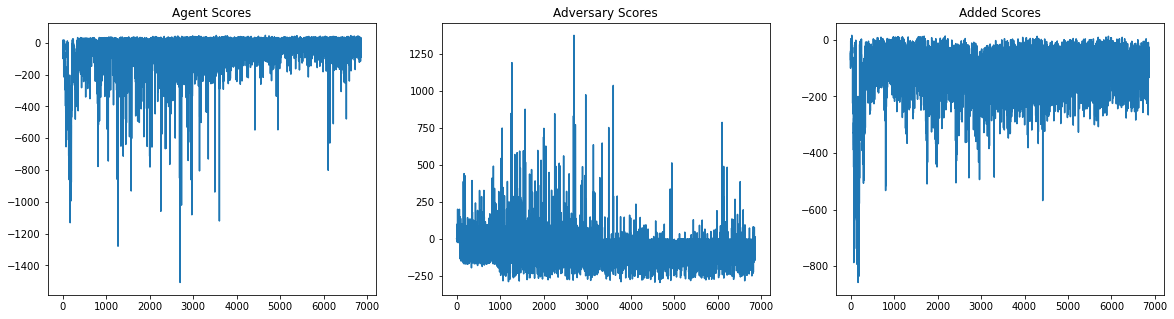

In [6]:
figure, axis = plt.subplots(1,3)
figure.set_figheight(5)
figure.set_figwidth(20)
axis[0].plot(agent_scores)
axis[0].set_title("Agent Scores")
axis[1].plot(adversary_scores)
axis[1].set_title("Adversary Scores")
axis[2].plot(final_scores)
axis[2].set_title("Added Scores")
        